<a href="https://colab.research.google.com/github/ahnchaeun/TimeOutPut/blob/master/CNN%20model%20with%20textbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [ ]:
dataset, info = tfds.load("colorectal_histology", as_supervised=True, with_info=True)
class_names = info.features["label"].names
dataset_size = info.splits["train"].num_examples
print(class_names)
print(dataset_size)

['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']
5000


In [ ]:
test_set, valid_set, train_set = tfds.load(
    "colorectal_histology",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

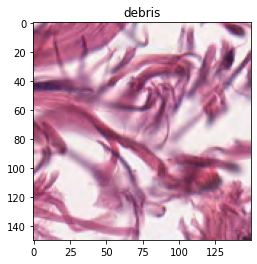

In [ ]:
get_label_name = info.features['label'].int2str

image, label = next(iter(train_set))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

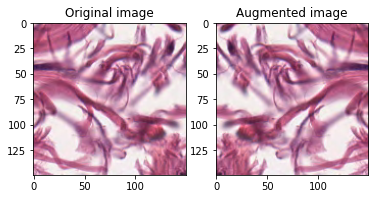

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

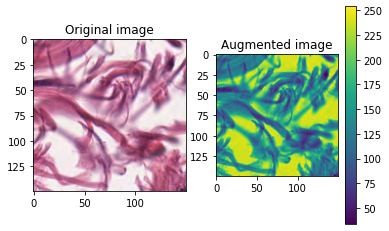

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_=plt.colorbar()

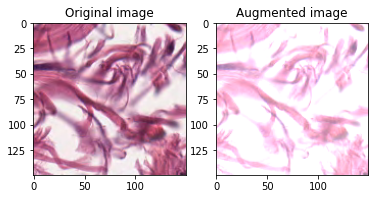

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

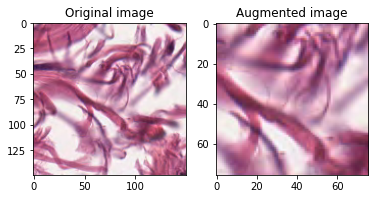

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

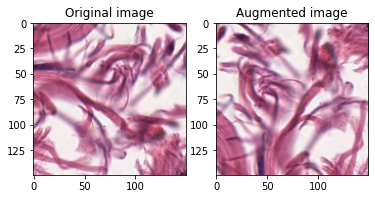

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [ ]:
def augment(image, label):
  image=tf.image.flip_left_right(image)
  tf.image.adjust_brightness(image, 0.4)
  return image,label

In [ ]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    return resized_image, label

batch_size = 32
train_set_real = train_set.shuffle(1000)
train_set_real = train_set_real.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set_real = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set_real = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=8, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 256)      

In [ ]:

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

from keras.callbacks import EarlyStopping

early_stopping = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5)]

history = model.fit(train_set_real, validation_data=valid_set_real, epochs = 40, callbacks = [early_stopping])



Epoch 1/40
118/118 [==============================] - 31s 240ms/step - loss: 10.6350 - accuracy: 0.1579 - val_loss: 1.9470 - val_accuracy: 0.1360
Epoch 2/40
118/118 [==============================] - 29s 241ms/step - loss: 1.8386 - accuracy: 0.2357 - val_loss: 2.0327 - val_accuracy: 0.1147
Epoch 3/40
118/118 [==============================] - 29s 242ms/step - loss: 2.0961 - accuracy: 0.2235 - val_loss: 1.9544 - val_accuracy: 0.2187
Epoch 4/40
118/118 [==============================] - 30s 245ms/step - loss: 1.8637 - accuracy: 0.2531 - val_loss: 1.5818 - val_accuracy: 0.2867
Epoch 5/40
118/118 [==============================] - 30s 245ms/step - loss: 1.7172 - accuracy: 0.2923 - val_loss: 2.0603 - val_accuracy: 0.1573
Epoch 6/40
118/118 [==============================] - 29s 242ms/step - loss: 1.7684 - accuracy: 0.2872 - val_loss: 1.5531 - val_accuracy: 0.2720
Epoch 7/40
118/118 [==============================] - 29s 242ms/step - loss: 1.5432 - accuracy: 0.3427 - val_loss: 1.3193 - val_a

In [ ]:
pred = model.predict(test_set_real)
loss, acc = model.evaluate(test_set_real)
print("Accuracy : ", acc)
print("Loss : ", loss)

16/16 [==============================] - 1s 82ms/step - loss: 0.8988 - accuracy: 0.6520
Accuracy :  0.6520000100135803
Loss :  0.898770272731781


Text(0.5, 1.0, 'Loss Curves')

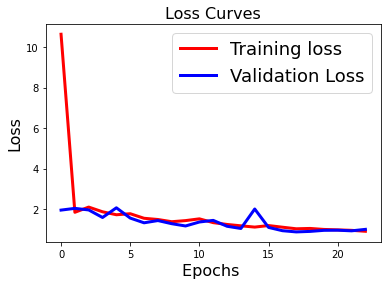

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

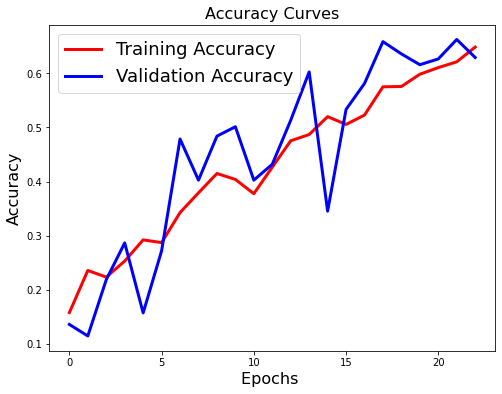

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
